In [1]:
# import library
import os
import cv2
import glob
import shutil
import random
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from tensorflow.keras.layers import Input
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications import InceptionV3

In [2]:
# set memory growth
physical_device = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [3]:
# kaggle.json downloaded >> https://drive.google.com/file/d/1x5RMQ3yp049uZIxtIqNg3PwFqOqAAcu3/view?usp=share_link
! pip install gdown
! gdown 1x5RMQ3yp049uZIxtIqNg3PwFqOqAAcu3
! ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1x5RMQ3yp049uZIxtIqNg3PwFqOqAAcu3
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 102kB/s]
kaggle.json  sample_data


In [4]:
# Connect the Kaggle API client
! pip install -q kaggle

# move API client in ~/.kaggle
! mkdir ~/.kaggle
! cp "/content/kaggle.json" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

# dataset downloaded >> https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
! kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification

100% 3.58G/3.58G [01:40<00:00, 40.2MB/s]
100% 3.58G/3.58G [01:40<00:00, 38.3MB/s]


In [5]:
# extract the zip file
local_zip = "/content/fruits-fresh-and-rotten-for-classification.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content")
zip_ref.close()

In [6]:
# remove unused files
shutil.rmtree("/content/dataset/dataset")
os.remove("fruits-fresh-and-rotten-for-classification.zip")

In [7]:
# show image functions
def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img

def show_data(rows,cols,is_train=True,transform=False):
    if is_train:
        path = '/content/dataset/train'
    else:
        path = '/content/dataset/test'
    path = os.path.join(path,'*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('/')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

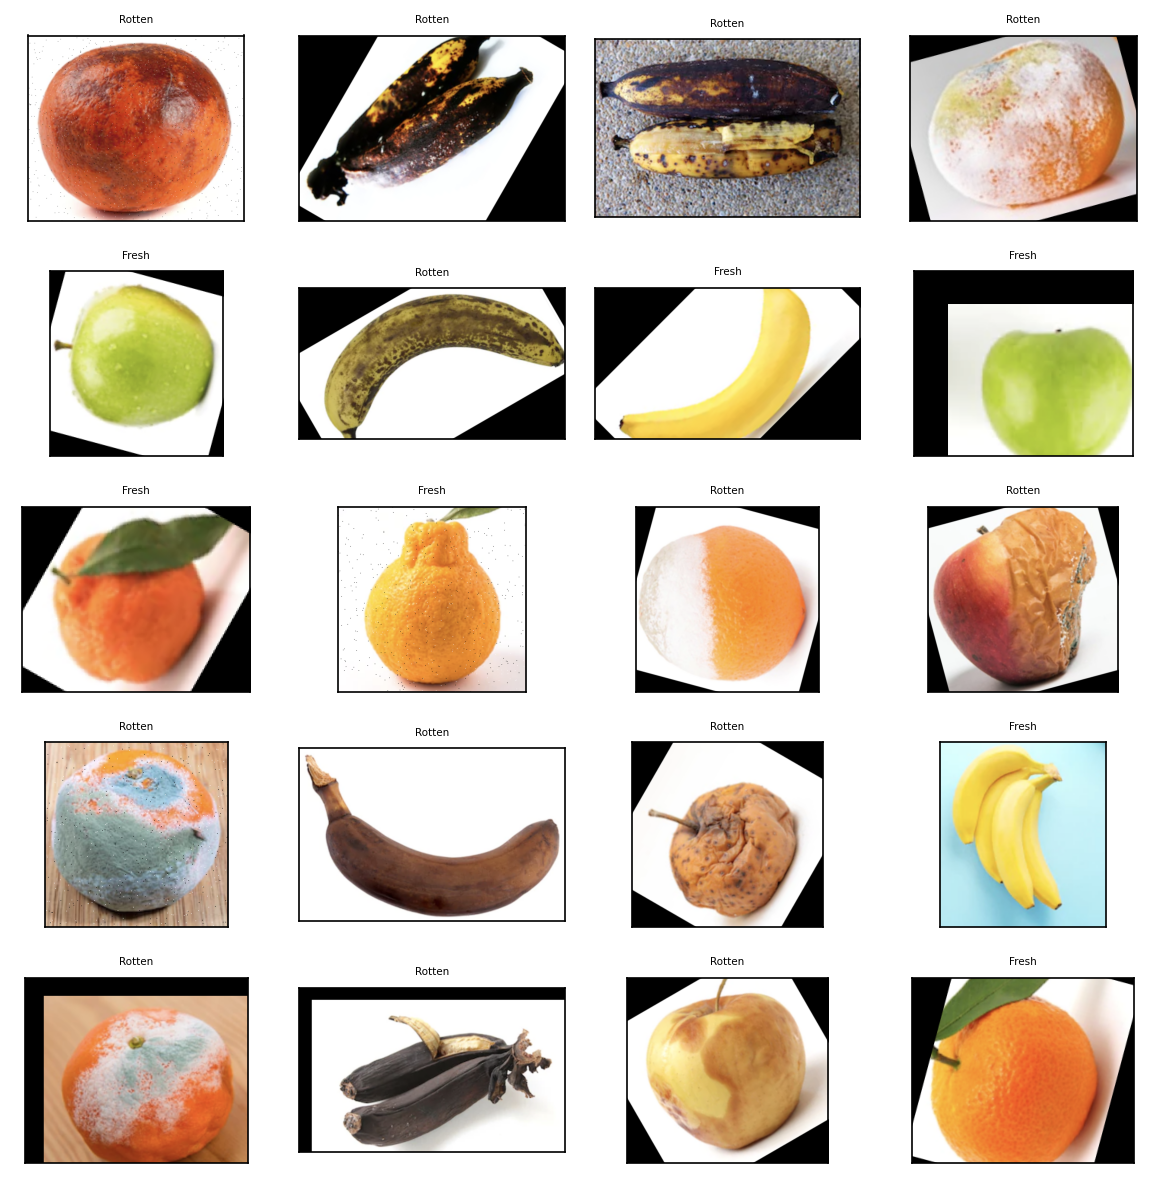

In [8]:
# show image in train set
fig = show_data(5,4)
fig.tight_layout()

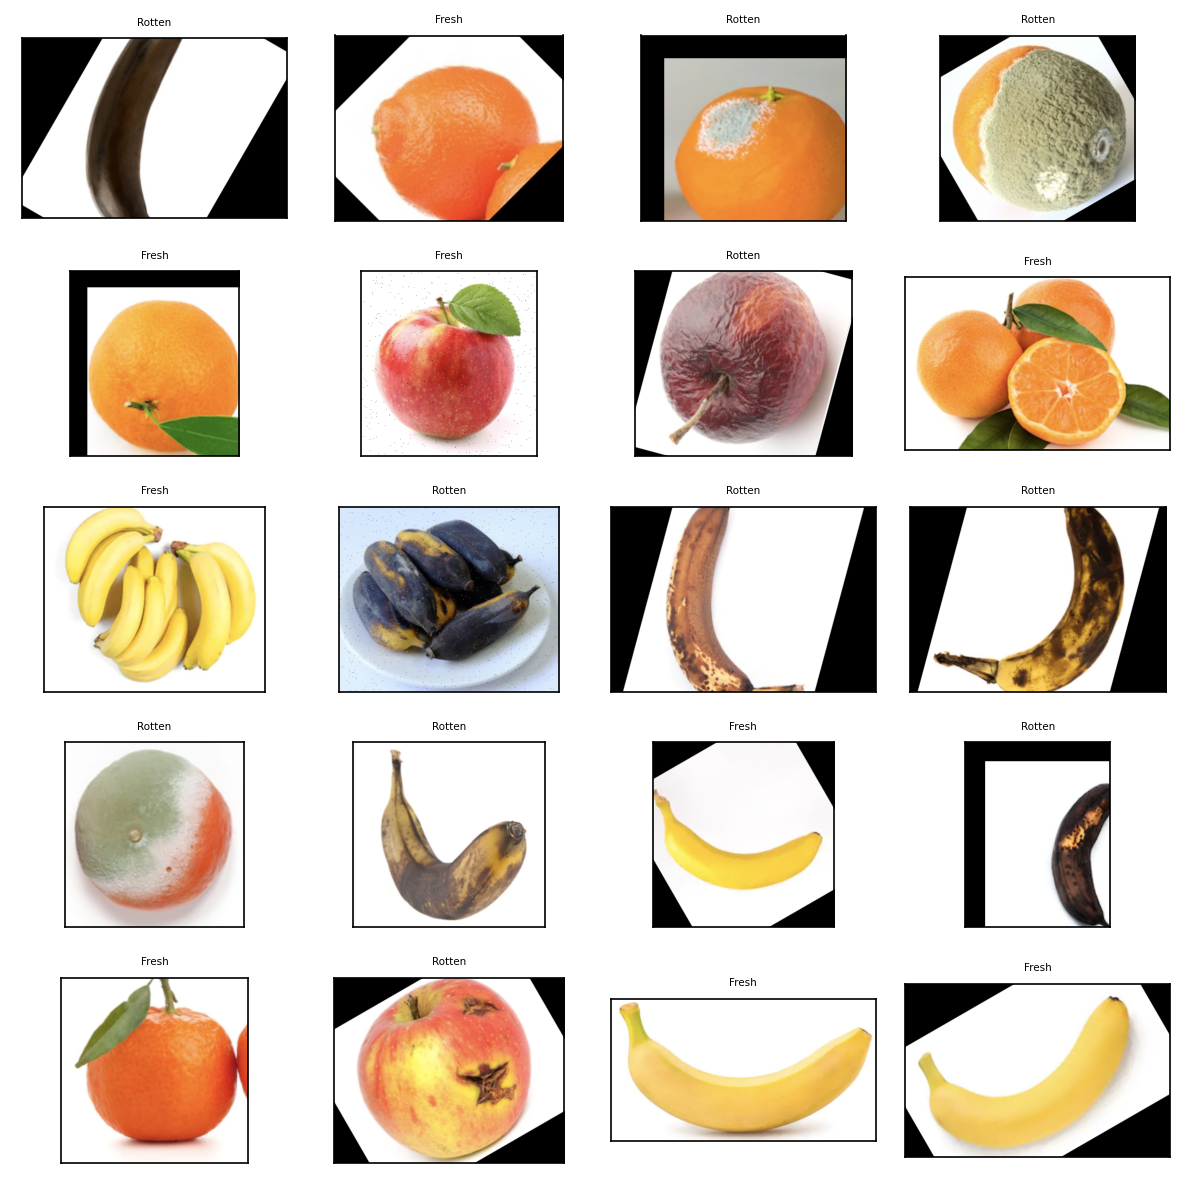

In [9]:
# show image in test set
fig = show_data(5,4,is_train=False)
fig.tight_layout()

In [10]:
# directory specification
base_dir = r"/content/dataset"

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "test")

# define label variables
labels = os.listdir(validation_dir)

In [11]:
# data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [12]:
# process image
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 15,
    target_size=(224, 224),
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 15,
    target_size=(224, 224),
    class_mode='categorical',)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [13]:
# create sequential models
pre_trained_model = ResNet50V2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

# freeze layers
for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


94668760/94668760 [==============================] - 3s 0us/step


In [14]:
# layers
x = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(len(labels), activation="softmax")(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [15]:
# initialization parameters
init_lr = 1e-3
batch_size = 15
num_epochs = 25

# optimizer and crossentropy loss
optimizer = tf.optimizers.Adam(learning_rate=init_lr, decay=init_lr/num_epochs)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# callbacks & checkpoint functions
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.99 and logs.get('val_accuracy') >= 0.99:
      print("\nTarget reached 99%. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

checkpoint_filepath = 'model/model_weights.{epoch:02d}-{val_loss:.3f}.h5'
checkpoint_save = tf.keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True)

In [17]:
# models training
history=model.fit(
      train_generator,
      epochs=30,
      steps_per_epoch=len(train_generator) // batch_size,
      validation_data=validation_generator,
      validation_steps=len(validation_generator) // batch_size,
      verbose=1,
      callbacks=[callbacks, checkpoint_save])

Epoch 1/30
48/48 [==============================] - 28s 256ms/step - loss: 1.1000 - accuracy: 0.6181 - val_loss: 0.3946 - val_accuracy: 0.8556
Epoch 2/30
48/48 [==============================] - 12s 241ms/step - loss: 0.4798 - accuracy: 0.8250 - val_loss: 0.2914 - val_accuracy: 0.8889
Epoch 3/30
48/48 [==============================] - 12s 252ms/step - loss: 0.3775 - accuracy: 0.8736 - val_loss: 0.2285 - val_accuracy: 0.9389
Epoch 4/30
48/48 [==============================] - 12s 256ms/step - loss: 0.3622 - accuracy: 0.8722 - val_loss: 0.2309 - val_accuracy: 0.9278
Epoch 5/30
48/48 [==============================] - 13s 265ms/step - loss: 0.3486 - accuracy: 0.8750 - val_loss: 0.2051 - val_accuracy: 0.9222
Epoch 6/30
48/48 [==============================] - 11s 240ms/step - loss: 0.2744 - accuracy: 0.9078 - val_loss: 0.2187 - val_accuracy: 0.9167
Epoch 7/30
48/48 [==============================] - 12s 251ms/step - loss: 0.3284 - accuracy: 0.8917 - val_loss: 0.2537 - val_accuracy: 0.9222

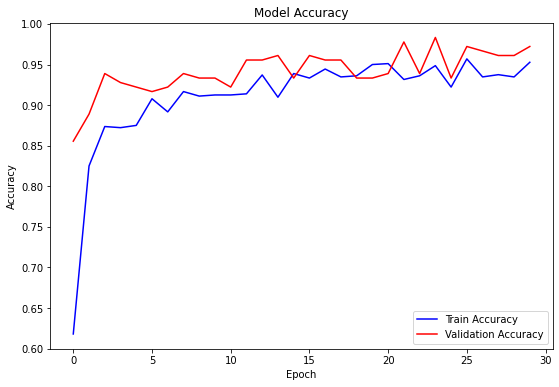

In [18]:
# plotting accuracy metrics
plt.figure(figsize=(9,6))

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

acc = plt.plot(history.history['accuracy'], color='blue')
val_acc = plt.plot(history.history['val_accuracy'], color='red')

plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')

plt.show()

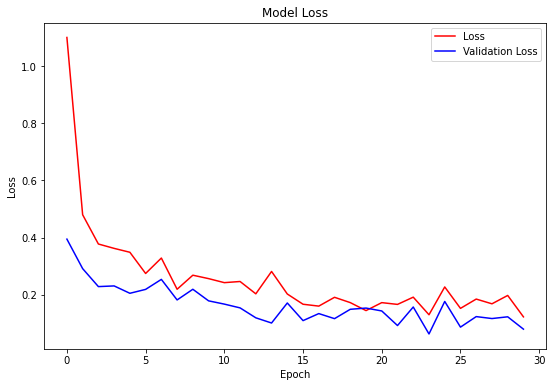

In [19]:
# plotting loss metrics
plt.figure(figsize=(9,6))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

loss = plt.plot(history.history['loss'], color='red')
val_loss = plt.plot(history.history['val_loss'], color='blue')

plt.legend(['Loss', 'Validation Loss'], loc='upper right')

plt.show()

In [20]:
# model conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

model.save("model.h5")

Saving pexels-any-lane-5945761.jpg to pexels-any-lane-5945761.jpg
1/1 [==============================] - 0s 25ms/step
pexels-any-lane-5945761.jpg is a Fresh Oranges


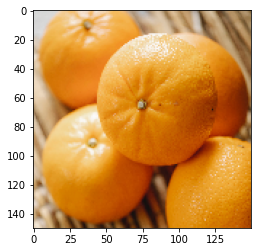

In [23]:
# predict image
%matplotlib inline
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  arr = model.predict(images, batch_size=10)
  if arr[0][0]==1:
    labels='Fresh Apple'
  elif arr[0][1]==1:
    labels='Fresh Banana'
  elif arr[0][2]==1:
    labels='Fresh Oranges'
  elif arr[0][3]==1:
    labels='Rotten Apple'
  elif arr[0][4]==1:
    labels='Rotten Banana'
  elif arr[0][5]==1:
    labels='Rotten Oranges'
print('{} is a {}'.format(fn,labels))